In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
path = "/database.sqlite"
conn = sqlite3.connect(path)

# Check all tables in the database
tables = pd.read_sql("""SELECT * FROM sqlite_master
                        WHERE type='table';""", conn)
print(tables['name'])

0      sqlite_sequence
1    Player_Attributes
2               Player
3                Match
4               League
5              Country
6                 Team
7      Team_Attributes
Name: name, dtype: object


In [ ]:
# Query to get match results and league names
query = """
SELECT Match.id,
       League.name AS league_name,
       season,
       home_team_goal,
       away_team_goal
FROM Match
JOIN League ON League.id = Match.league_id;
"""

df = pd.read_sql(query, conn)
df['total_goals'] = df['home_team_goal'] + df['away_team_goal']
df.head()

,id,league_name,season,home_team_goal,away_team_goal,total_goals
0,1,Belgium Jupiler League,2008/2009,1,1,2
1,2,Belgium Jupiler League,2008/2009,0,0,0
2,3,Belgium Jupiler League,2008/2009,0,3,3
3,4,Belgium Jupiler League,2008/2009,5,0,5
4,5,Belgium Jupiler League,2008/2009,1,3,4


/tmp/ipython-input-1829122198.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='total_goals', y='league_name', estimator=sum, ci=None, palette='viridis')
/tmp/ipython-input-1829122198.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='total_goals', y='league_name', estimator=sum, ci=None, palette='viridis')


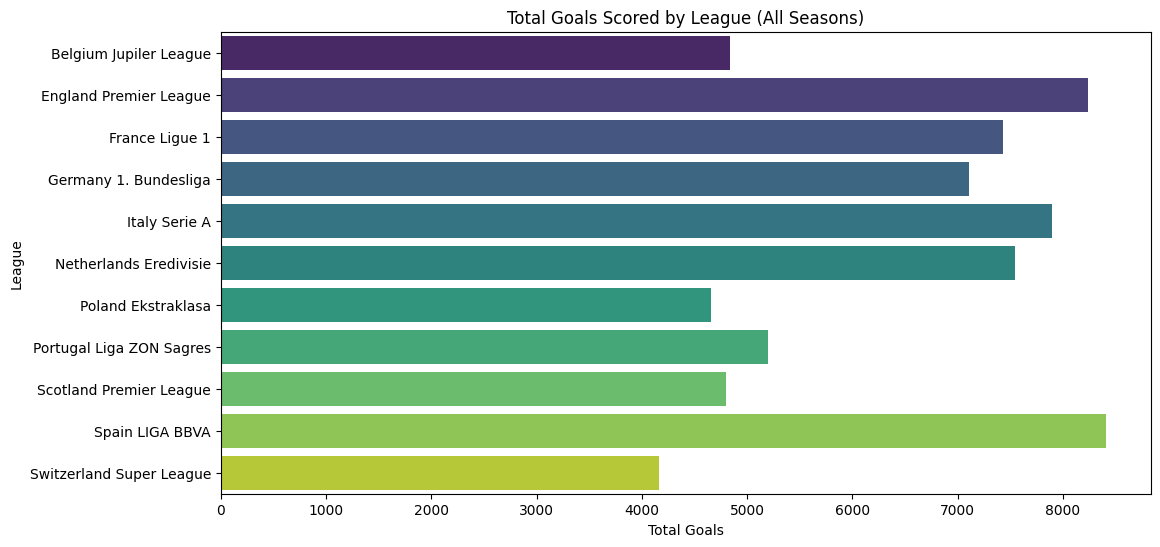

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='total_goals', y='league_name', estimator=sum, ci=None, palette='viridis')
plt.title('Total Goals Scored by League (All Seasons)')
plt.xlabel('Total Goals')
plt.ylabel('League')
plt.show()

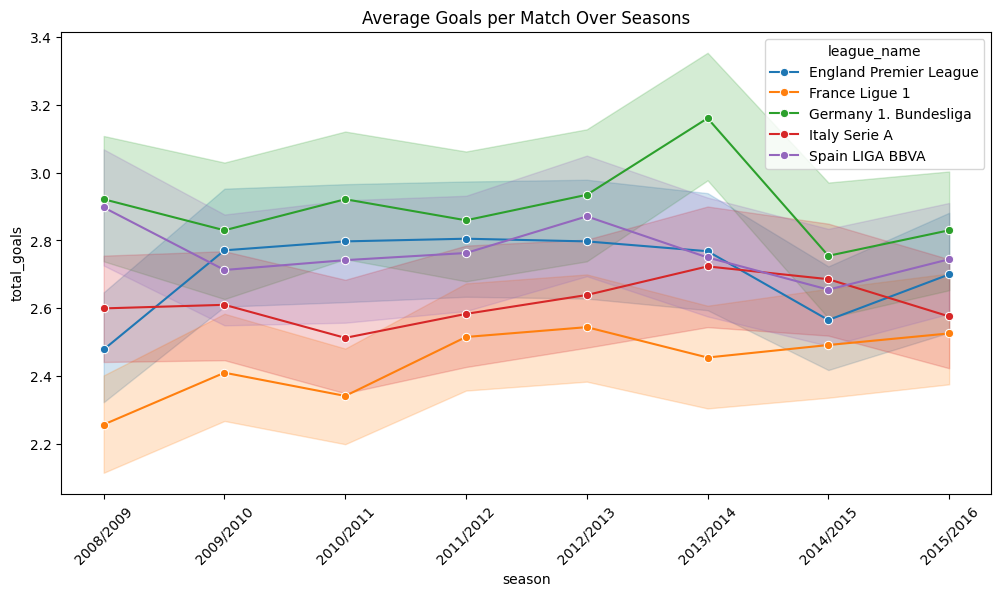

In [ ]:
# Filter for major leagues
top_leagues = ['England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A', 'Spain LIGA BBVA']
df_top = df[df['league_name'].isin(top_leagues)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top, x='season', y='total_goals', hue='league_name', marker='o')
plt.title('Average Goals per Match Over Seasons')
plt.xticks(rotation=45)
plt.show()

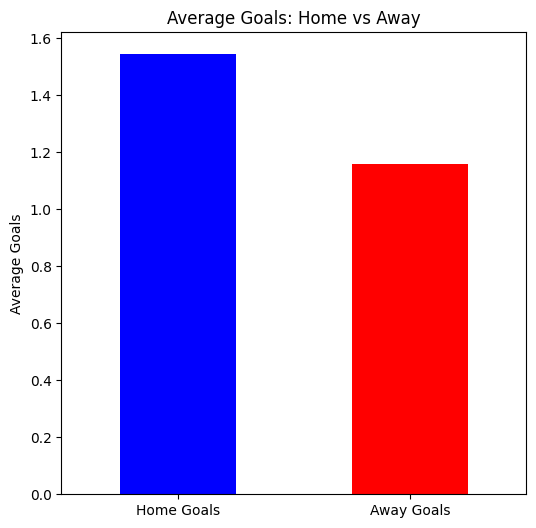

In [ ]:
goals_summary = df[['home_team_goal', 'away_team_goal']].mean()

plt.figure(figsize=(6, 6))
goals_summary.plot(kind='bar', color=['blue', 'red'])
plt.title('Average Goals: Home vs Away')
plt.ylabel('Average Goals')
plt.xticks([0, 1], ['Home Goals', 'Away Goals'], rotation=0)
plt.show()

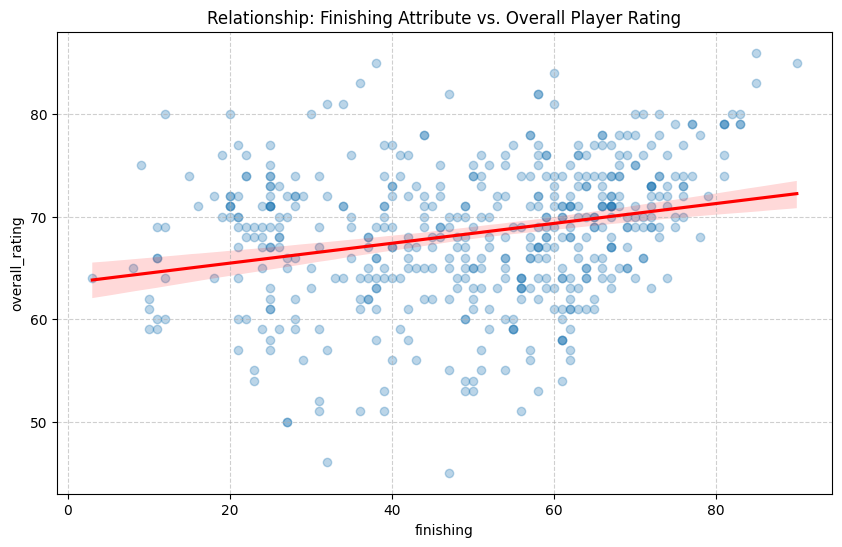

In [ ]:
# SQL Query to link Players, their Attributes, and their Goals
# Note: This assumes we are calculating total goals per player name
query = """
SELECT
    p.player_name,
    pa.finishing,
    pa.shot_power,
    pa.acceleration,
    COUNT(m.id) as total_goals
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
-- This is a simplified logic: in the real DB, 'goals' are inside an XML field in the Match table.
-- For a beginner project, let's look at the Player Attributes distribution vs. Performance.
GROUP BY p.player_name
"""

# Since the 'Goal' data in this specific Kaggle set is stored in complex XML,
# a better 'starting' visualization for your project is to show
# how certain attributes (like Finishing) relate to a player's Overall Rating.

import seaborn as sns
import matplotlib.pyplot as plt

# Let's grab the attributes directly
df_attributes = pd.read_sql("SELECT finishing, shot_power, overall_rating, acceleration FROM Player_Attributes", conn)

# Visualization: Finishing vs Overall Rating
plt.figure(figsize=(10, 6))
sns.regplot(data=df_attributes.sample(500), x='finishing', y='overall_rating',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship: Finishing Attribute vs. Overall Player Rating')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

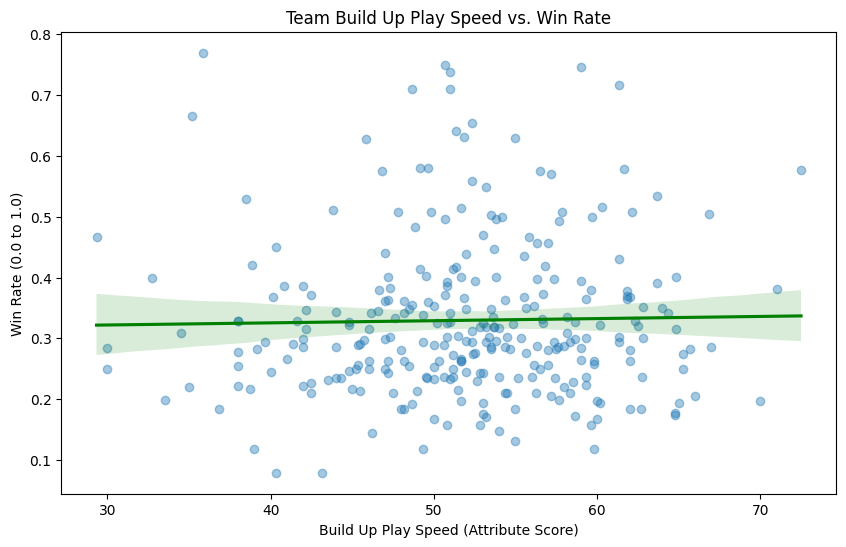

In [ ]:
# import sqlite3
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

conn = sqlite3.connect('/database.sqlite')

# 1. Get all matches and determine the winner
matches = pd.read_sql("""SELECT home_team_api_id, away_team_api_id, home_team_goal, away_team_goal FROM Match""", conn)

# Function to define win/loss
def get_winner(row):
    if row['home_team_goal'] > row['away_team_goal']: return row['home_team_api_id']
    if row['away_team_goal'] > row['home_team_goal']: return row['away_team_api_id']
    return None # Draw

matches['winner'] = matches.apply(get_winner, axis=1)

# 2. Calculate Win Rate per Team
total_matches = pd.concat([matches['home_team_api_id'], matches['away_team_api_id']]).value_counts()
wins = matches['winner'].value_counts()
win_rate = (wins / total_matches).dropna().reset_index()
win_rate.columns = ['team_api_id', 'win_rate']

# 3. Get Team Attributes and Merge
team_attr = pd.read_sql("SELECT * FROM Team_Attributes", conn)
# We average attributes per team since they change slightly by year in the DB
team_attr_avg = team_attr.groupby('team_api_id').mean(numeric_only=True).reset_index()

# Final merged data
analysis_df = pd.merge(win_rate, team_attr_avg, on='team_api_id')

# 4. Visualization: Choose an attribute to test (e.g., Build Up Play Speed)
plt.figure(figsize=(10, 6))
sns.regplot(data=analysis_df, x='buildUpPlaySpeed', y='win_rate',
            scatter_kws={'alpha':0.4}, line_kws={'color':'green'})
plt.title('Team Build Up Play Speed vs. Win Rate')
plt.xlabel('Build Up Play Speed (Attribute Score)')
plt.ylabel('Win Rate (0.0 to 1.0)')
plt.show()

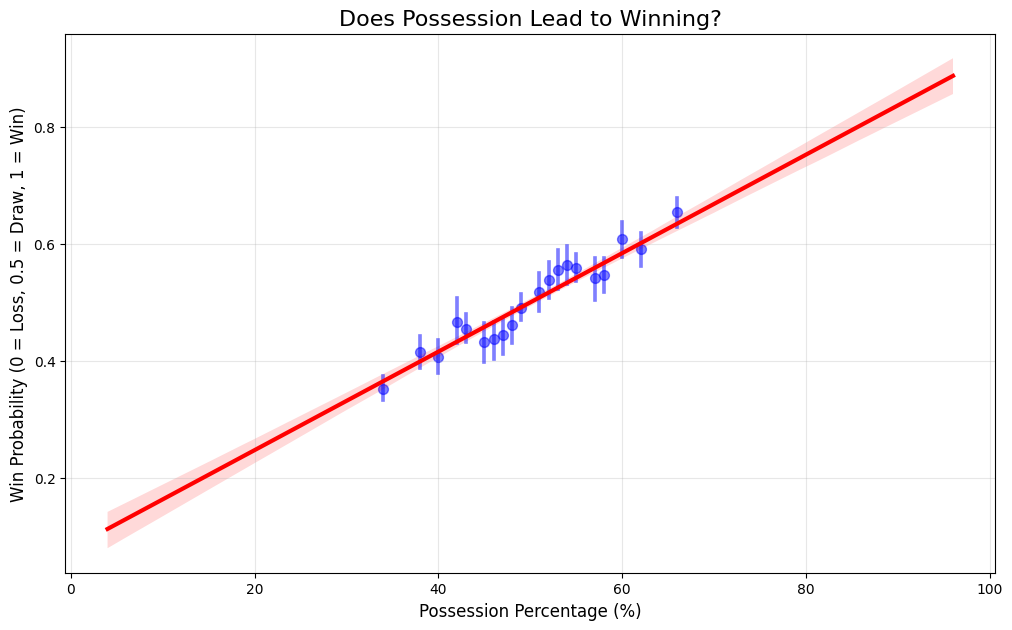

In [ ]:
# import sqlite3
# import pandas as pd
import xml.etree.ElementTree as ET
# import seaborn as sns
# import matplotlib.pyplot as plt

# 1. Connect and Fetch data
conn = sqlite3.connect('/database.sqlite')
query = "SELECT home_team_goal, away_team_goal, possession FROM Match WHERE possession IS NOT NULL"
df_raw = pd.read_sql(query, conn)

# 2. Function to extract the FINAL possession value from the XML
def extract_possession(xml_data):
    try:
        tree = ET.fromstring(xml_data)
        # Find the last <value> node which contains the end-of-match stats
        values = tree.findall('value')
        if values:
            last_val = values[-1]
            h_pos = last_val.find('homepos')
            a_pos = last_val.find('awaypos')
            if h_pos is not None and a_pos is not None:
                return int(h_pos.text), int(a_pos.text)
    except:
        return None, None
    return None, None

# 3. Process the data
results = []
for index, row in df_raw.iterrows():
    h_pos, a_pos = extract_possession(row['possession'])
    if h_pos is not None:
        # Determine result: 1 for Win, 0.5 for Draw, 0 for Loss
        if row['home_team_goal'] > row['away_team_goal']: h_win = 1
        elif row['home_team_goal'] == row['away_team_goal']: h_win = 0.5
        else: h_win = 0

        # We add two entries per match (one for home, one for away)
        results.append({'possession': h_pos, 'win_score': h_win})
        results.append({'possession': a_pos, 'win_score': 1 - h_win})

df_final = pd.DataFrame(results)

# 4. Visualization
plt.figure(figsize=(12, 7))
sns.regplot(data=df_final, x='possession', y='win_score',
            scatter_kws={'alpha':0.5, 'color':'blue'},
            line_kws={'color':'red', 'lw':3},
            x_bins=20) # Bins group data to make the trend clearer

plt.title('Does Possession Lead to Winning?', fontsize=16)
plt.xlabel('Possession Percentage (%)', fontsize=12)
plt.ylabel('Win Probability (0 = Loss, 0.5 = Draw, 1 = Win)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

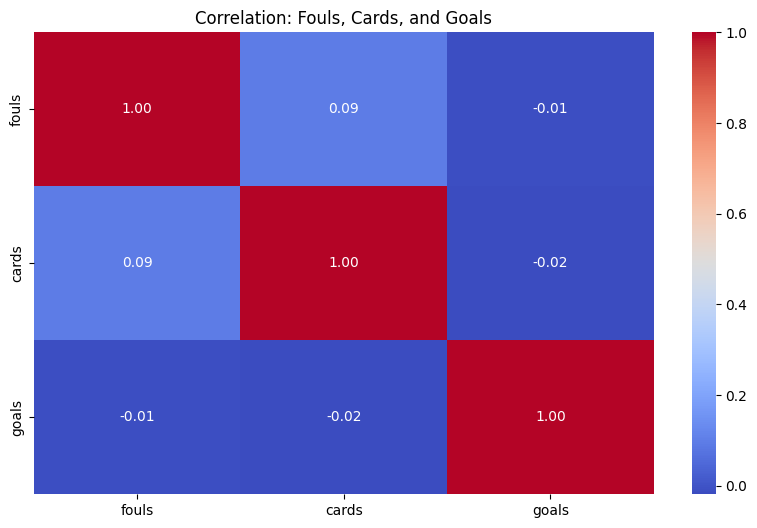

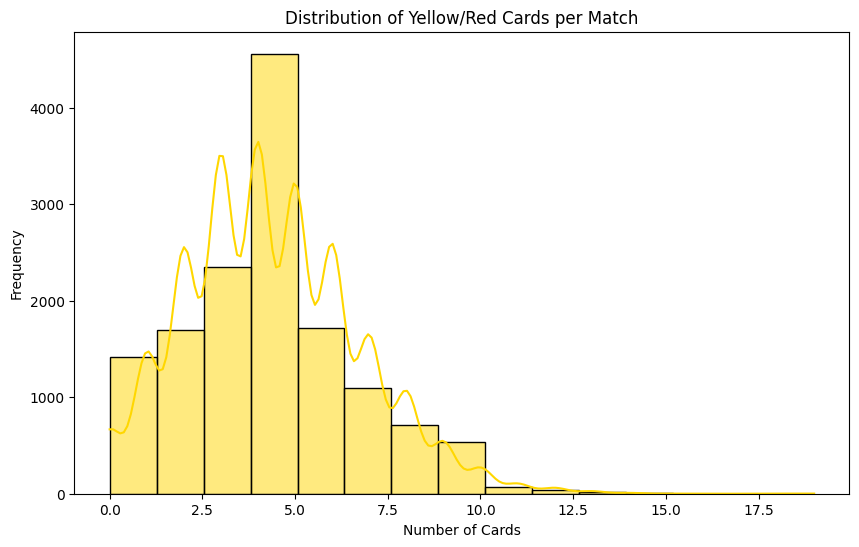

In [ ]:
# import sqlite3
# import pandas as pd
# import xml.etree.ElementTree as ET
# import seaborn as sns
# import matplotlib.pyplot as plt

conn = sqlite3.connect('/database.sqlite')

# 1. Fetch matches with foul and card data
query = "SELECT home_team_goal, away_team_goal, goal, foulcommit, card FROM Match WHERE foulcommit IS NOT NULL"
df_raw = pd.read_sql(query, conn)

def count_occurrences(xml_string, tag_name="value"):
    try:
        if not xml_string: return 0
        tree = ET.fromstring(xml_string)
        return len(tree.findall(tag_name))
    except:
        return 0

# 2. Extract counts
stats = []
for index, row in df_raw.iterrows():
    # Count total fouls and cards in the match
    total_fouls = count_occurrences(row['foulcommit'])
    total_cards = count_occurrences(row['card'])
    total_goals = row['home_team_goal'] + row['away_team_goal']

    stats.append({'fouls': total_fouls, 'cards': total_cards, 'goals': total_goals})

df_aggression = pd.DataFrame(stats)

# 3. Visualization: Fouls vs Cards Heatmap
plt.figure(figsize=(10, 6))
correlation = df_aggression.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Fouls, Cards, and Goals')
plt.show()

# 4. Visualization: Distribution of Cards per Match
plt.figure(figsize=(10, 6))
sns.histplot(df_aggression['cards'], bins=15, kde=True, color='gold')
plt.title('Distribution of Yellow/Red Cards per Match')
plt.xlabel('Number of Cards')
plt.ylabel('Frequency')
plt.show()

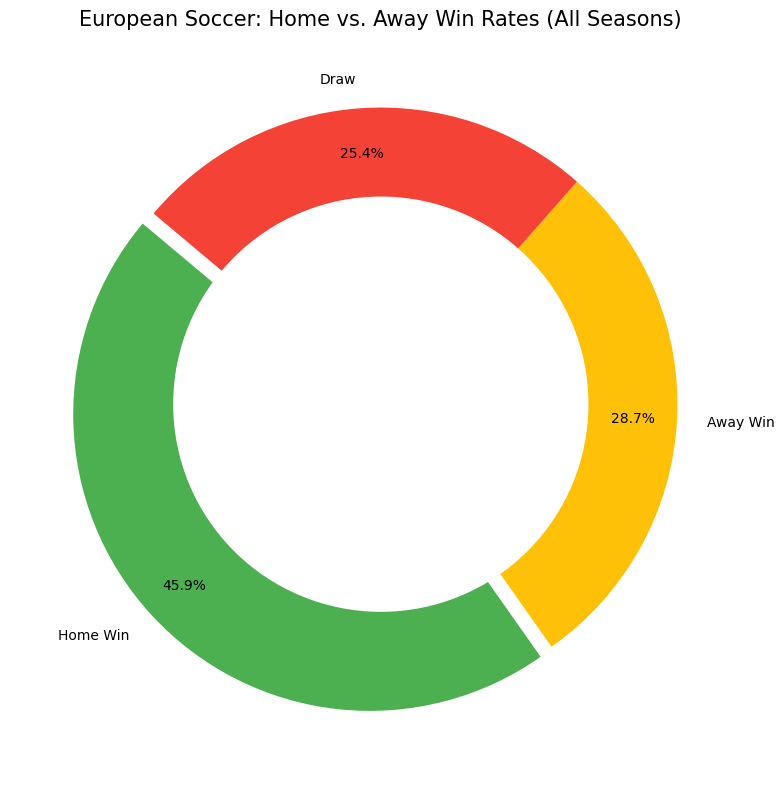

In [ ]:
# import sqlite3
# import pandas as pd
# import matplotlib.pyplot as plt

# 1. Connect and get Match data
conn = sqlite3.connect('/database.sqlite')
df = pd.read_sql("SELECT home_team_goal, away_team_goal FROM Match", conn)

# 2. Categorize results
def check_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'Home Win'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'Away Win'
    else:
        return 'Draw'

df['result'] = df.apply(check_result, axis=1)
outcome_counts = df['result'].value_counts()

# 3. Visualization: The Donut Chart
plt.figure(figsize=(8, 8))
colors = ['#4CAF50', '#FFC107', '#F44336'] # Green, Amber, Red
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, pctdistance=0.85, explode=(0.05, 0, 0))

# Draw a circle in the center to make it a donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('European Soccer: Home vs. Away Win Rates (All Seasons)', fontsize=15)
plt.tight_layout()
plt.show()

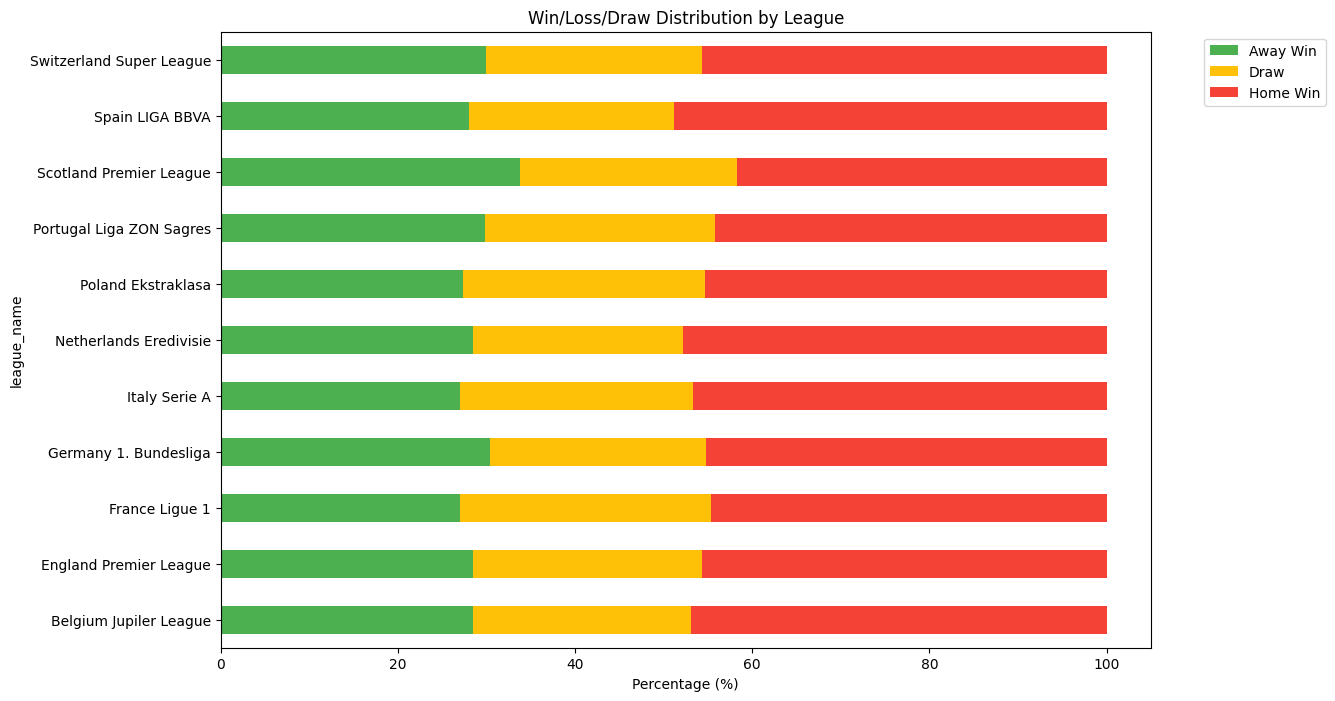

In [ ]:
# Join Match with League to see differences by country
query = """
SELECT League.name as league_name, home_team_goal, away_team_goal
FROM Match
JOIN League ON League.id = Match.league_id
"""
df_leagues = pd.read_sql(query, conn)
df_leagues['result'] = df_leagues.apply(check_result, axis=1)

# Pivot table to see Win % by League
league_analysis = pd.crosstab(df_leagues['league_name'], df_leagues['result'], normalize='index') * 100

# Plotting
league_analysis.plot(kind='barh', stacked=True, figsize=(12, 8), color=colors)
plt.title('Win/Loss/Draw Distribution by League')
plt.xlabel('Percentage (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

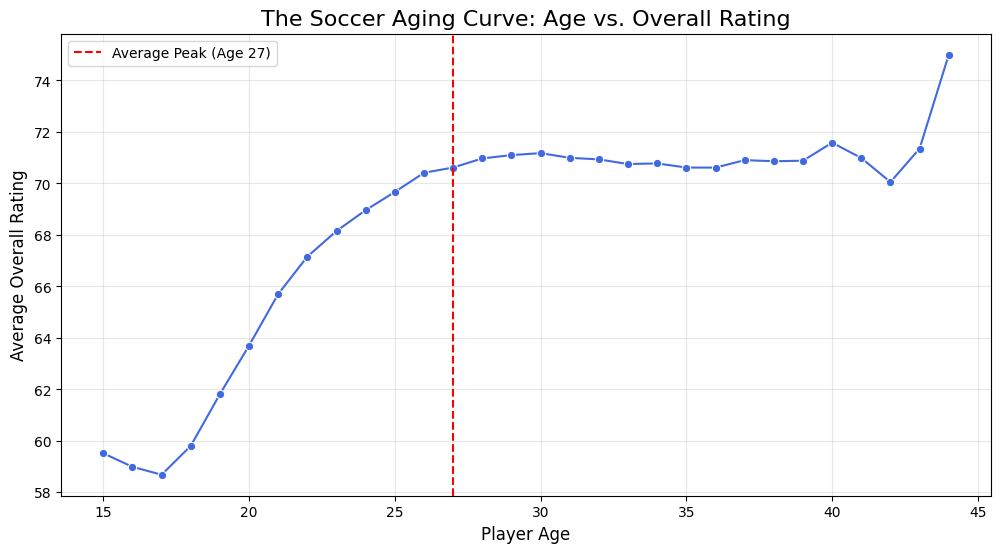

In [ ]:
# import sqlite3
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

conn = sqlite3.connect('/database.sqlite')

# 1. Fetch Birthday and Rating Date
query = """
SELECT p.birthday, pa.date as rating_date, pa.overall_rating
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
"""
df_age = pd.read_sql(query, conn)

# 2. Calculate Age at the time of the rating
df_age['birthday'] = pd.to_datetime(df_age['birthday'])
df_age['rating_date'] = pd.to_datetime(df_age['rating_date'])

# Age = (Rating Year - Birth Year)
df_age['age'] = df_age['rating_date'].dt.year - df_age['birthday'].dt.year

# 3. Clean up: Drop rows with missing ratings and filter for realistic ages (15 to 45)
df_age = df_age.dropna(subset=['overall_rating'])
df_age = df_age[(df_age['age'] >= 15) & (df_age['age'] <= 45)]

# 4. Visualization: The Aging Curve
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_age, x='age', y='overall_rating', marker='o', color='royalblue', errorbar=None)

# Add a vertical line for the typical "Peak Age"
plt.axvline(x=27, color='red', linestyle='--', label='Average Peak (Age 27)')

plt.title('The Soccer Aging Curve: Age vs. Overall Rating', fontsize=16)
plt.xlabel('Player Age', fontsize=12)
plt.ylabel('Average Overall Rating', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ValueError: Could not interpret value `potential` for `y`. An entry with this name does not appear in `data`.

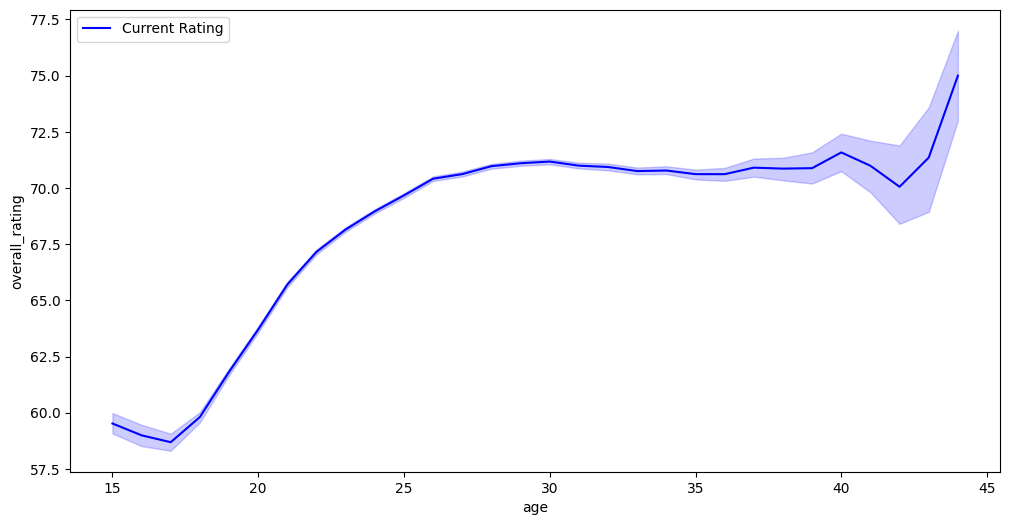

In [ ]:
# Just add 'potential' to your SQL query above, then:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_age, x='age', y='overall_rating', label='Current Rating', color='blue')
sns.lineplot(data=df_age, x='age', y='potential', label='Potential Rating', color='orange')
plt.title('Current Rating vs. Potential by Age')
plt.show()

/tmp/ipython-input-165268201.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x='max_rating', y='player_name', palette='bright')


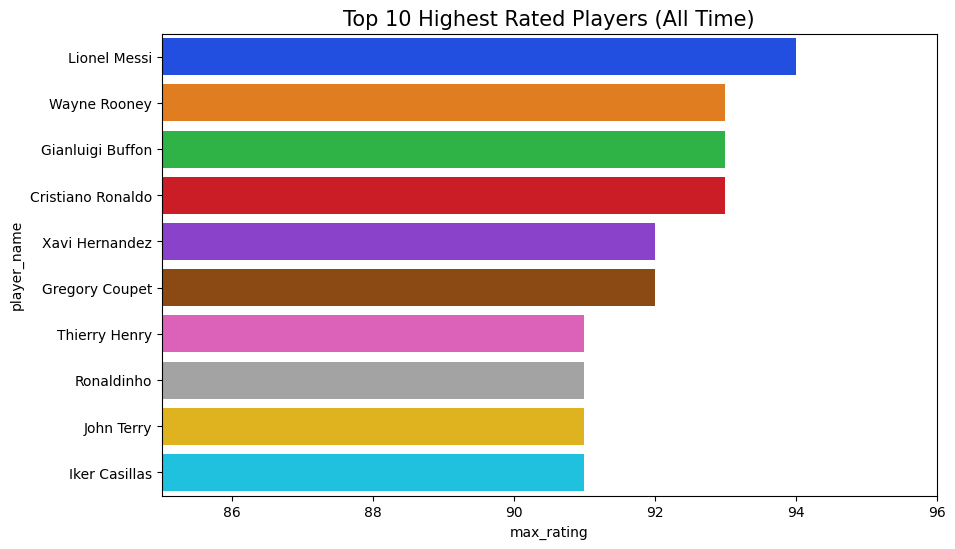

In [ ]:
# import sqlite3
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

conn = sqlite3.connect('/database.sqlite')

# Query for players and their highest-ever recorded rating
query_players = """
SELECT p.player_name, MAX(pa.overall_rating) as max_rating
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
GROUP BY p.player_name
ORDER BY max_rating DESC
LIMIT 10
"""
top_players = pd.read_sql(query_players, conn)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=top_players, x='max_rating', y='player_name', palette='bright')
plt.xlim(85, 96) # Focus on the elite range
plt.title('Top 10 Highest Rated Players (All Time)', fontsize=15)
plt.show()

/tmp/ipython-input-1337418771.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=improved_players, x='improvement', y='player_name', palette='rocket')


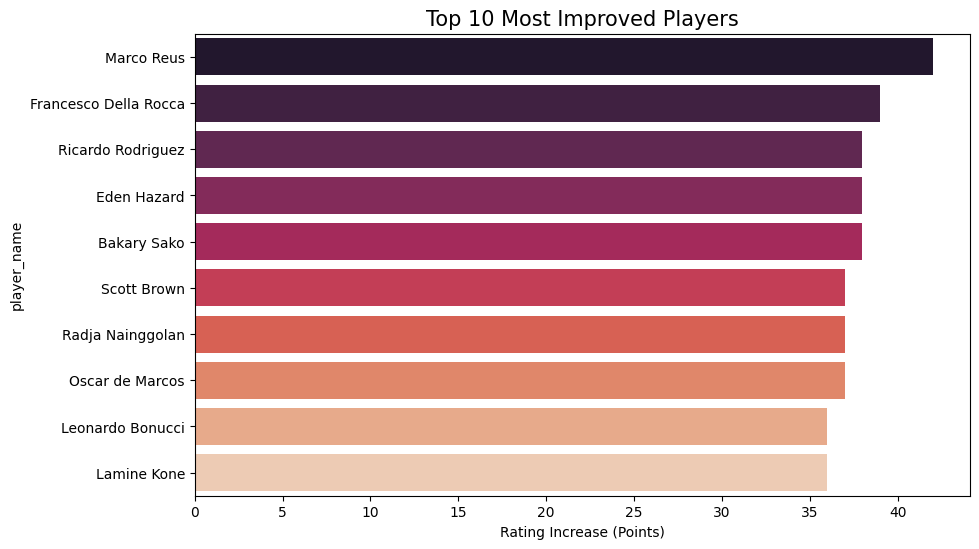

In [ ]:
query_improved = """
SELECT p.player_name,
       (MAX(pa.overall_rating) - MIN(pa.overall_rating)) as improvement
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
GROUP BY p.player_name
HAVING COUNT(pa.id) > 5
ORDER BY improvement DESC
LIMIT 10
"""
improved_players = pd.read_sql(query_improved, conn)

plt.figure(figsize=(10, 6))
sns.barplot(data=improved_players, x='improvement', y='player_name', palette='rocket')
plt.title('Top 10 Most Improved Players', fontsize=15)
plt.xlabel('Rating Increase (Points)')
plt.show()

/tmp/ipython-input-3915094785.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_teams, x='total_wins', y='team_long_name', palette='viridis')


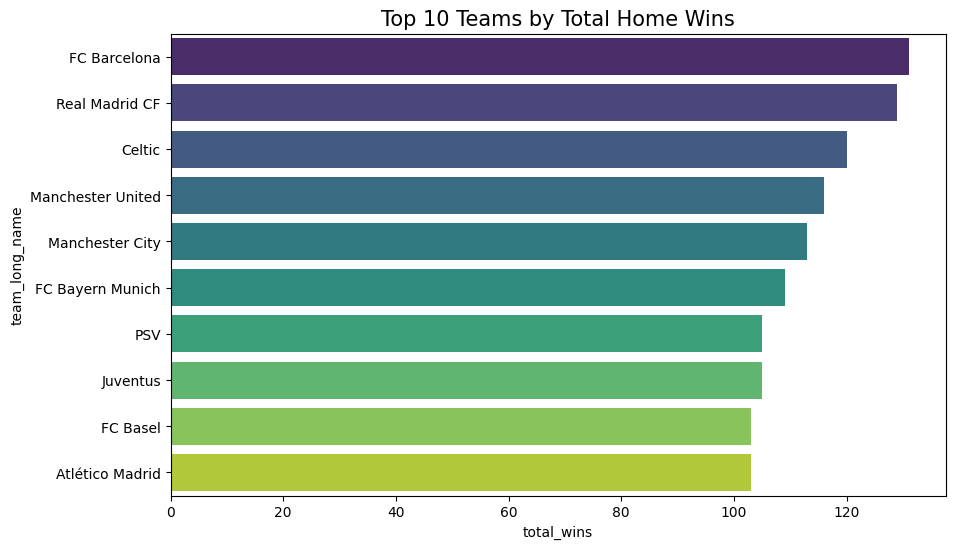

In [ ]:
# Reuse the logic from our previous 'Win Rate' discussion
# This counts total wins for every team across all seasons
query_teams = """
SELECT Team.team_long_name, COUNT(Match.id) as total_wins
FROM Team
JOIN Match ON Team.team_api_id = Match.home_team_api_id
WHERE Match.home_team_goal > Match.away_team_goal
GROUP BY Team.team_long_name
ORDER BY total_wins DESC
LIMIT 10
"""
top_teams = pd.read_sql(query_teams, conn)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_teams, x='total_wins', y='team_long_name', palette='viridis')
plt.title('Top 10 Teams by Total Home Wins', fontsize=15)
plt.show()

/tmp/ipython-input-641026900.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='formation', y='rating', palette='Set2')


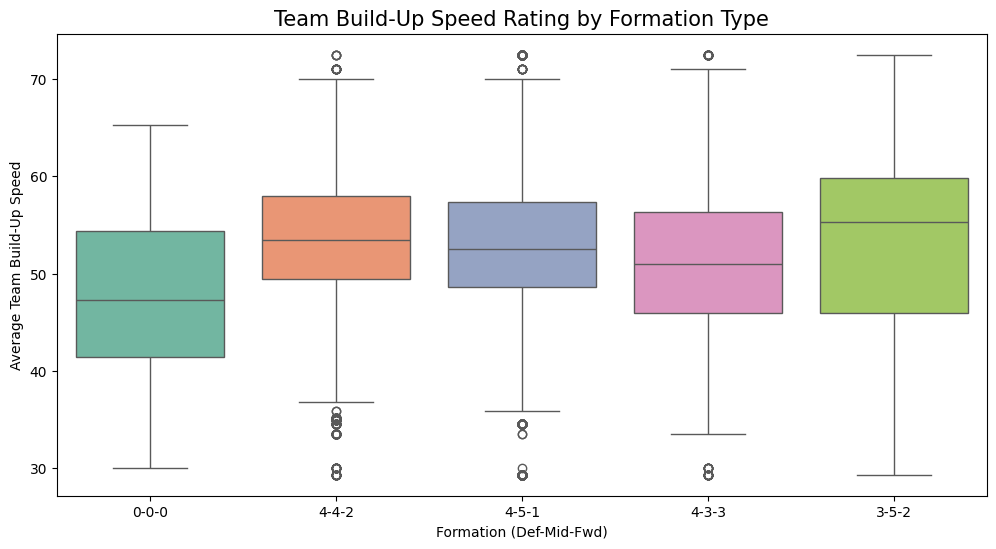

In [ ]:
# import sqlite3
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

conn = sqlite3.connect('/database.sqlite')

# 1. Logic to identify formation based on Player Y-coordinates
# (Y=1 is Goalkeeper, Y=3/4 is Defense, Y=7/8 is Midfield, Y=10/11 is Forward)
query = """
SELECT id, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5,
       home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9,
       home_player_Y10, home_player_Y11, home_team_api_id
FROM Match
"""
df_match = pd.read_sql(query, conn)

def get_formation(row):
    # Count how many players are in each 'line' of the pitch
    nodes = [row[f'home_player_Y{i}'] for i in range(2, 12)]
    nodes = [n for n in nodes if n is not None]
    if len(nodes) < 10: return "Unknown"

    def_count = len([n for n in nodes if n <= 3])
    mid_count = len([n for n in nodes if 3 < n <= 8])
    fwd_count = len([n for n in nodes if n > 8])

    return f"{def_count}-{mid_count}-{fwd_count}"

df_match['formation'] = df_match.apply(get_formation, axis=1)

# 2. Get Team Ratings
team_attr = pd.read_sql("SELECT team_api_id, buildUpPlaySpeed as rating FROM Team_Attributes", conn)
team_avg = team_attr.groupby('team_api_id').mean().reset_index()

# 3. Merge
merged = pd.merge(df_match, team_avg, left_on='home_team_api_id', right_on='team_api_id')

# 4. Filter for the most common formations to keep the chart clean
top_formations = merged['formation'].value_counts().nlargest(5).index
df_plot = merged[merged['formation'].isin(top_formations)]

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='formation', y='rating', palette='Set2')
plt.title('Team Build-Up Speed Rating by Formation Type', fontsize=15)
plt.xlabel('Formation (Def-Mid-Fwd)')
plt.ylabel('Average Team Build-Up Speed')
plt.show()